##Data Analysis and Pre-processing

Importing libraries: we import relevant Python libraries for this.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

We load the data onto a Pandas Dataframe for ease of visualizing and handling the data.

In [2]:
raw_data = pd.read_excel('data.xlsx')
raw_data.head()

,Date,No_of_calls_from_commercial_card,No_of_calls_from_retail_card,No_of_calls_from_student_card
0,2017-01-01,264.0,403.0,860.0
1,2017-01-02,528.0,792.0,1681.0
2,2017-01-03,2505.0,3774.0,7639.0
3,2017-01-04,2145.0,3236.0,6513.0
4,2017-01-05,2164.0,3265.0,6604.0


<!-- Having made the "Date" column the index, a row accessed now will contain only the call data. -->
 We now analyze the calls following the first year, which apparently are in a random order.

In [3]:
# Storing values for the first year of the three columns.

comm_first = raw_data['No_of_calls_from_commercial_card'][:365]
retail_first = raw_data['No_of_calls_from_retail_card'][:365]
student_first = raw_data['No_of_calls_from_student_card'][:365]

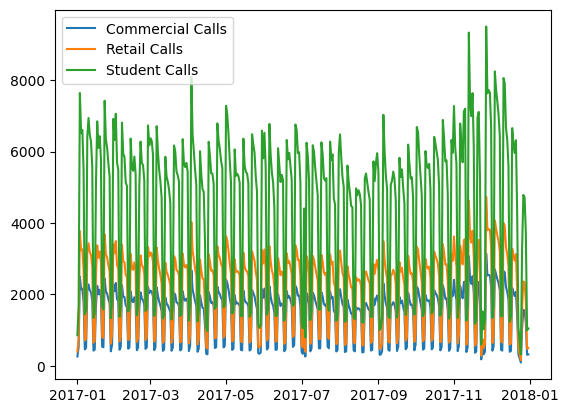

In [4]:
plt.plot(raw_data['Date'][:365], comm_first)
plt.plot(raw_data['Date'][:365], retail_first)
plt.plot(raw_data['Date'][:365], student_first)
plt.legend(['Commercial Calls', 'Retail Calls', 'Student Calls'], loc='upper left')
plt.show()

It is evident from this graph that for all rows, the order is commercial card < retail card < student card. However, we run a loop through every row of the first one year to confirm.

In [5]:
def checkOrder(student, commercial, retail):
  output = []
  for i in range (365):
      if (student[i]<retail[i] or student[i]<commercial[i] or retail[i]<commercial[i]):
          output.append(i)

  return output

output = checkOrder(student_first, comm_first, retail_first)
if len(output)!=0:
  print(output)
else:
  print("Student calls > Retail calls > Commercial calls")

Student calls > Retail calls > Commercial calls


Clearly, for every day, student calls are always the highest, followed by retail and commercial. Let us sort the remaining rows according to this. For doing this, we make the "Date" column the index, so that any row accessed has only call values.

In [6]:
raw_data.set_index("Date", inplace=True)

In [7]:
for i in range(1673):
  w = raw_data.iloc[i].values
  w.sort()
  raw_data.iloc[i][0] = w[0]
  raw_data.iloc[i][1] = w[1]
  raw_data.iloc[i][2] = w[2]

We save this corrected data to a csv file.

In [8]:
raw_data.to_csv("correct_data.csv", index=True)

As required by the problem statement, we create an excel sheet with the correct data for the commercial card calls.

In [9]:
commercial_card = raw_data[['No_of_calls_from_commercial_card']].copy()
commercial_card.head()

,No_of_calls_from_commercial_card
Date,
2017-01-01,264.0
2017-01-02,528.0
2017-01-03,2505.0
2017-01-04,2145.0
2017-01-05,2164.0


In [10]:
commercial_card.to_excel("commercial_card_data.xlsx", index=True)

In [11]:
correct_data = pd.read_csv('correct_data.csv')

In [12]:
correct_data = correct_data.iloc[:-92,:] #the last 92 rows are null values, hence removing them.

Have a look at the call data for all the three years, for the three cards.

In [13]:
commercial_card = correct_data[['Date','No_of_calls_from_commercial_card']].copy()
retail_card = correct_data[['Date','No_of_calls_from_retail_card']].copy()
student_card = correct_data[['Date','No_of_calls_from_student_card']].copy()

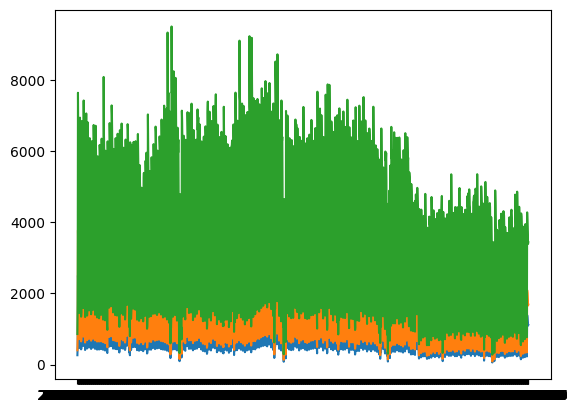

In [14]:
plt.plot(correct_data['Date'][:], commercial_card.iloc[:,1])
plt.plot(correct_data['Date'][:], retail_card.iloc[:,1])
plt.plot(correct_data['Date'][:], student_card.iloc[:,1])
plt.show()

We find a pattern here, which shows that on weekends, the calls fall drastically. View it here.

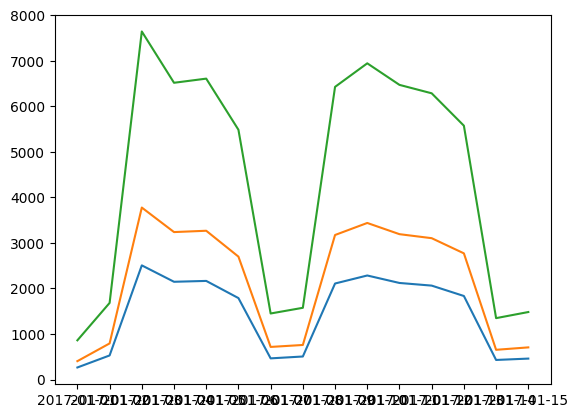

In [15]:
plt.plot(correct_data['Date'][:15], commercial_card.iloc[:15,1])
plt.plot(correct_data['Date'][:15], retail_card.iloc[:15,1])
plt.plot(correct_data['Date'][:15], student_card.iloc[:15,1])
plt.show()

Therefore, to consider this while training, let us encode the day as well.

In [16]:
day = [i%7 for i in range(1581)]

In [17]:
new_data = correct_data
new_data['day'] = day
print(new_data.head())
new_data.shape

         Date  No_of_calls_from_commercial_card  No_of_calls_from_retail_card  \
0  2017-01-01                             264.0                         403.0   
1  2017-01-02                             528.0                         792.0   
2  2017-01-03                            2505.0                        3774.0   
3  2017-01-04                            2145.0                        3236.0   
4  2017-01-05                            2164.0                        3265.0   

   No_of_calls_from_student_card  day  
0                          860.0    0  
1                         1681.0    1  
2                         7639.0    2  
3                         6513.0    3  
4                         6604.0    4  


(1581, 5)

Instead of simple numbers, let us instead encode the days with the sum of the calls of the respective card on every occurrence of that day.

In [18]:
commercials = np.empty((7,))
students = np.empty((7,))
retails = np.empty((7,))

for i in range(7):
  commercials[i] = new_data[new_data['day']==i]['No_of_calls_from_commercial_card'].sum()
  students[i] = new_data[new_data['day']==i]['No_of_calls_from_student_card'].sum()
  retails[i] = new_data[new_data['day']==i]['No_of_calls_from_retail_card'].sum()

print(commercials, students, retails)

[ 88531. 425170. 424392. 405112. 391126. 355613.  96966.] [ 281640. 1291397. 1287875. 1231015. 1189596. 1082564.  306137.] [135072. 639968. 638766. 609860. 589052. 535701. 147517.]


In [19]:
data = new_data
comm_day = np.empty((1581,1))
stu_day = np.empty((1581,1))
ret_day = np.empty((1581,1))

for i in range(1581):
  day_code = data.iloc[i]['day']
  comm_day[i] = commercials[day_code]
  stu_day[i] = students[day_code]
  ret_day[i] = retails[day_code]

data['commercial_day'] = comm_day
data['student_day'] = stu_day
data['retail_day'] = ret_day

In [20]:
data = data.drop('day', axis=1)
data.head(15)

,Date,No_of_calls_from_commercial_card,No_of_calls_from_retail_card,No_of_calls_from_student_card,commercial_day,student_day,retail_day
0,2017-01-01,264.0,403.0,860.0,88531.0,281640.0,135072.0
1,2017-01-02,528.0,792.0,1681.0,425170.0,1291397.0,639968.0
2,2017-01-03,2505.0,3774.0,7639.0,424392.0,1287875.0,638766.0
3,2017-01-04,2145.0,3236.0,6513.0,405112.0,1231015.0,609860.0
4,2017-01-05,2164.0,3265.0,6604.0,391126.0,1189596.0,589052.0
5,2017-01-06,1787.0,2697.0,5482.0,355613.0,1082564.0,535701.0
6,2017-01-07,464.0,715.0,1449.0,96966.0,306137.0,147517.0
7,2017-01-08,505.0,758.0,1574.0,88531.0,281640.0,135072.0
8,2017-01-09,2107.0,3172.0,6423.0,425170.0,1291397.0,639968.0
9,2017-01-10,2283.0,3436.0,6940.0,424392.0,1287875.0,638766.0


With this now, let us define our training and testing datasets. We keep the ratio of train:test large, as the last few months of calls are considerably smaller, and this should reflect while training.

In [21]:
train_data = data.iloc[:1500,:]
test_data = data.iloc[1500:,:]
train_data.head()

,Date,No_of_calls_from_commercial_card,No_of_calls_from_retail_card,No_of_calls_from_student_card,commercial_day,student_day,retail_day
0,2017-01-01,264.0,403.0,860.0,88531.0,281640.0,135072.0
1,2017-01-02,528.0,792.0,1681.0,425170.0,1291397.0,639968.0
2,2017-01-03,2505.0,3774.0,7639.0,424392.0,1287875.0,638766.0
3,2017-01-04,2145.0,3236.0,6513.0,405112.0,1231015.0,609860.0
4,2017-01-05,2164.0,3265.0,6604.0,391126.0,1189596.0,589052.0


For normalizing the data, the Scikit-Learn package provides the MinMaxScaler function.

In [22]:
scaler = MinMaxScaler()

In [23]:
train_data = scaler.fit_transform(train_data.drop('Date', axis=1))
test_data = scaler.fit_transform(test_data.drop('Date',axis=1))

In [24]:
train_data = pd.DataFrame(train_data)
test_data = pd.DataFrame(test_data)

In [25]:
train_data

,0,1,2,3,4,5
0,0.066105,0.067399,0.063096,0.000000,0.000000,0.000000
1,0.151653,0.151163,0.152103,1.000000,1.000000,1.000000
2,0.792288,0.793282,0.798027,0.997689,0.996512,0.997619
3,0.675632,0.677433,0.675954,0.940417,0.940201,0.940368
4,0.681789,0.683678,0.685820,0.898871,0.899183,0.899155
...,...,...,...,...,...,...
1495,0.428386,0.427864,0.424328,0.898871,0.899183,0.899155
1496,0.384316,0.384152,0.377168,0.793378,0.793185,0.793488
1497,0.093325,0.096038,0.094753,0.025057,0.024260,0.024649
1498,0.043746,0.044789,0.036101,0.000000,0.000000,0.000000


In [26]:
test_data

,0,1,2,3,4,5
0,0.705400,0.708257,0.722403,0.997689,0.996512,0.997619
1,0.708817,0.708257,0.721011,0.940417,0.940201,0.940368
2,0.713602,0.710550,0.705705,0.898871,0.899183,0.899155
3,0.578264,0.581651,0.583488,0.793378,0.793185,0.793488
4,0.116883,0.111009,0.112245,0.025057,0.024260,0.024649
...,...,...,...,...,...,...
76,0.848941,0.849541,0.865028,1.000000,1.000000,1.000000
77,0.810663,0.812844,0.809369,0.997689,0.996512,0.997619
78,0.731374,0.728899,0.739564,0.940417,0.940201,0.940368
79,0.645249,0.650917,0.659323,0.898871,0.899183,0.899155


For creating the timeseries dataset, we break the data into windows, with the target value for each window being the very next value.

In [27]:
def sliding_window(data, window):
  x = []
  y = []
  for i in range(data.shape[0] - window - 1):
    x_data = data.iloc[i:(i+window)].to_numpy()
    x.append(x_data)
    y_data = data.iloc[[i+window],:].to_numpy()
    y.append(y_data)

  return np.array(x), np.array(y)

Let us define the window size as two weeks.

In [28]:
input_dim=6
window=14

In [29]:
X_train, y_train = sliding_window(train_data, window)
X_test, y_test = sliding_window(test_data, window)

With this, we have completed the preprocessing of the data.



---



---



##Prediction
We start off by importing libraries.

In [30]:
import torch
import torch.nn as nn
from torch import optim

And then converting our data into PyTorch tensors for inputting into our model.

In [31]:
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

In [32]:
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

Here, we define the model, its layers, and the parameters. We make use of the LSTM() module of torch.nn class.

In [33]:
class CallForecast(nn.Module):

  def __init__(self, input_dim, hidden_dim, seq_length, num_layers=2):
    super(CallForecast, self).__init__()
    self.input_dim = input_dim
    self.hidden_dim = hidden_dim
    self.seq_length = seq_length
    self.num_layers = num_layers
    self.lstm = nn.LSTM(
      input_size=self.input_dim, # is of the form "input, (h_0, c_0)"
      hidden_size=self.hidden_dim,
      num_layers=num_layers,
      dropout=0.2
    )

    self.linear = nn.Linear(self.hidden_dim, self.input_dim) #the last linear layer

  def reset_hidden_state(self):
    self.hidden = (
      torch.zeros(self.num_layers, self.seq_length, self.hidden_dim),
      torch.zeros(self.num_layers, self.seq_length, self.hidden_dim)
    )

  def forward(self, input):
    lstm_out, self.hidden = self.lstm(
        input.view(len(input), self.seq_length, -1),
        self.hidden # See reset state
    )
    y_pred = self.linear(
        lstm_out.view(len(input), self.seq_length, self.hidden_dim)[:,-1,:]
    )
    y_pred = torch.unsqueeze(y_pred,dim=1)
    return y_pred

Now to define the training model, making use of the model class defined earlier. We use the MSE loss function and the Adam optimizer, running for 100 epochs.

In [34]:
def train_model(model, train_data, train_labels, test_data=None, test_labels=None):
  loss_fn = nn.MSELoss()

  optimiser = optim.Adam(model.parameters(), lr=1e-3)

  epochs = 100

  train_hist = np.zeros(epochs)
  test_hist = np.zeros(epochs)

  for t in range(epochs):

    model.reset_hidden_state()

    y_pred = model(X_train)

    loss = loss_fn(y_pred.float(), y_train)

    if test_data is not None:
      with torch.no_grad():
        y_test_pred = model(X_test)
        test_loss = loss_fn(y_test_pred.float(), y_test)
      test_hist[t] = test_loss.item()

      if t % 10 == 0:
        print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')


    elif t % 10 == 0:
      print(f'Epoch {t} train loss: {loss.item()}')

    train_hist[t] = loss.item()

    optimiser.zero_grad()

    loss.backward()

    optimiser.step()
  if test_data is not None:
    return model.eval(), train_hist, test_hist
  else:
    return model.eval(), train_hist

Our input dimension is 6, since there are 6 columns. Let us train the model with the data we have curated.

In [35]:
model = CallForecast(6, 64, seq_length=window, num_layers=2)

model, train_hist, test_hist = train_model(model, X_train, y_train, X_test, y_test)

Epoch 0 train loss: 0.4779033958911896 test loss: 0.5861619114875793
Epoch 10 train loss: 0.310784250497818 test loss: 0.39535874128341675
Epoch 20 train loss: 0.15416082739830017 test loss: 0.174347385764122
Epoch 30 train loss: 0.13025027513504028 test loss: 0.16616342961788177
Epoch 40 train loss: 0.12017608433961868 test loss: 0.14673970639705658
Epoch 50 train loss: 0.11891614645719528 test loss: 0.15263201296329498
Epoch 60 train loss: 0.11807893961668015 test loss: 0.1514592468738556
Epoch 70 train loss: 0.11767470091581345 test loss: 0.1469573825597763
Epoch 80 train loss: 0.11737947165966034 test loss: 0.1484200656414032
Epoch 90 train loss: 0.11659912019968033 test loss: 0.14601367712020874


Finally, for predicting the following one week, we use the trained model.

In [36]:
with torch.no_grad():

  test_seq = y_test[-window:]
  test_seq = test_seq.reshape(1,window,input_dim)
  preds = []
  for _ in range(7):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred)
    preds.append(pred)

    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, pred)
    new_seq = new_seq[input_dim:]
    test_seq = torch.as_tensor(new_seq).view(1, window, input_dim).float()

In [37]:
pred_tensor = torch.cat([preds[i] for i in range(len(preds))])
pred_tensor = pred_tensor.reshape(7,input_dim)
pred_tensor

tensor([[0.4459, 0.4376, 0.4422, 0.6706, 0.6647, 0.6679],
        [0.4467, 0.4351, 0.4433, 0.6682, 0.6622, 0.6653],
        [0.4471, 0.4344, 0.4431, 0.6676, 0.6630, 0.6648],
        [0.4467, 0.4346, 0.4423, 0.6676, 0.6643, 0.6646],
        [0.4459, 0.4350, 0.4412, 0.6676, 0.6654, 0.6644],
        [0.4449, 0.4354, 0.4401, 0.6676, 0.6663, 0.6643],
        [0.4440, 0.4358, 0.4392, 0.6675, 0.6668, 0.6641]])

The predicted week now can be viewed as a dataframe.

In [38]:
pred_week = pd.DataFrame(pred_tensor.numpy())
pred_week

,0,1,2,3,4,5
0,0.445869,0.437626,0.442159,0.670551,0.664749,0.667902
1,0.446668,0.435059,0.443267,0.668165,0.662237,0.665258
2,0.447068,0.434426,0.443113,0.667597,0.663035,0.664754
3,0.446678,0.434565,0.442253,0.667568,0.664310,0.664561
4,0.445889,0.434982,0.441190,0.667620,0.665447,0.664449
5,0.444946,0.435420,0.440146,0.667611,0.666286,0.664303
6,0.444001,0.435777,0.439217,0.667516,0.666839,0.664110


We should now inverse transform this considering the same parameters used for the train and test dataset.

In [39]:
scaler.fit(data.iloc[:1500,:].drop("Date",axis=1))
predicted_week = scaler.inverse_transform(pred_week)

In [40]:
predicted_week = pd.DataFrame(predicted_week, columns=['No_of_calls_from_commercial_card', 'No_of_calls_from_retail_card', 'No_of_calls_from_student_card','Commercial_Day','Student_Day','Retail_Day'])
predicted_week

,No_of_calls_from_commercial_card,No_of_calls_from_retail_card,No_of_calls_from_student_card,Commercial_Day,Student_Day,Retail_Day
0,1435.952393,2122.335205,4356.475098,314264.65625,952874.5000,472292.87500
1,1438.417969,2110.412842,4366.696777,313461.50000,950338.0000,470958.25000
2,1439.651367,2107.472412,4365.276367,313270.03125,951144.6875,470703.40625
3,1438.448853,2108.117676,4357.339355,313260.46875,952431.1250,470606.18750
4,1436.013306,2110.057373,4347.533203,313277.81250,953580.1250,470549.65625
5,1433.103149,2112.089844,4337.910156,313274.81250,954426.4375,470475.78125
6,1430.187500,2113.746338,4329.335449,313242.96875,954985.1875,470378.53125


Similarly, let us predict the coming three months, that is till 31-7-21.

In [41]:
with torch.no_grad():

  test_seq = y_test[-window:]
  test_seq = test_seq.reshape(1,window,input_dim)
  rest_preds = []
  for _ in range(92):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred)
    rest_preds.append(pred)

    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, pred)
    new_seq = new_seq[input_dim:]
    test_seq = torch.as_tensor(new_seq).view(1, window, input_dim).float()

In [42]:
pred_tensor = torch.cat([rest_preds[i] for i in range(len(rest_preds))])
pred_tensor = pred_tensor.reshape(92,input_dim)

predicted = pd.DataFrame(pred_tensor.numpy())

predicted = scaler.inverse_transform(predicted)
predicted = pd.DataFrame(predicted, columns=['No_of_calls_from_commercial_card', 'No_of_calls_from_retail_card', 'No_of_calls_from_student_card','Commercial_Day','Student_Day','Retail_Day'])
predicted

,No_of_calls_from_commercial_card,No_of_calls_from_retail_card,No_of_calls_from_student_card,Commercial_Day,Student_Day,Retail_Day
0,1433.281982,2113.120850,4351.236816,313985.18750,955287.6875,471631.71875
1,1433.546997,2110.745605,4346.448730,313457.56250,953503.0625,470587.65625
2,1432.931763,2111.225830,4340.558594,313262.37500,953752.8750,470369.00000
3,1431.114014,2112.300293,4333.344727,313181.81250,954277.5000,470261.06250
4,1428.851440,2113.491699,4326.206543,313131.65625,954757.6875,470186.09375
...,...,...,...,...,...,...
87,1414.738281,2115.052246,4292.268555,312517.09375,955092.6875,469340.87500
88,1414.738281,2115.052246,4292.268555,312517.09375,955092.6875,469340.87500
89,1414.738281,2115.052246,4292.268555,312517.09375,955092.6875,469340.87500
90,1414.738281,2115.052246,4292.268555,312517.09375,955092.6875,469340.87500


Now, we will save this into the original dataframe.

In [43]:
raw_data_copy = raw_data

In [44]:
last_preds = predicted[['No_of_calls_from_commercial_card', 'No_of_calls_from_retail_card', 'No_of_calls_from_student_card']].copy()

for i in range(last_preds.shape[0]):
  c = raw_data_copy.iloc[:-92,:].shape[0]
  raw_data_copy.iloc[c+i] = last_preds.iloc[i]

raw_data_copy.tail(10)

,No_of_calls_from_commercial_card,No_of_calls_from_retail_card,No_of_calls_from_student_card
Date,,,
2021-07-22,1414.738281,2115.052246,4292.268555
2021-07-23,1414.738281,2115.052246,4292.268555
2021-07-24,1414.738281,2115.052246,4292.268555
2021-07-25,1414.738281,2115.052246,4292.268555
2021-07-26,1414.738281,2115.052246,4292.268555
2021-07-27,1414.738281,2115.052246,4292.268555
2021-07-28,1414.738281,2115.052246,4292.268555
2021-07-29,1414.738281,2115.052246,4292.268555
2021-07-30,1414.738281,2115.052246,4292.268555


Finally, we save this to an excel sheet.

In [45]:
raw_data_copy.to_excel("predicted_data.xlsx", index=True)